# Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports ########################################
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm
# End notebooks specific imports ####################################

# Basic useful imports
import yaml
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
from scipy.spatial import cKDTree

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# From alens_analysis
import alens_analysis as aa
import alens_analysis.chromatin as aac


# Locations
alens_data_path = Path.home() / 'projects/DATA/Spindle/'

graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

In [2]:
from scipy.spatial.transform import Rotation as R

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    # Normalize vectors
    vec1 = vec1 / np.linalg.norm(vec1)
    vec2 = vec2 / np.linalg.norm(vec2)

    # Compute the cross product and dot product
    cross_prod = np.cross(vec1, vec2)
    dot_prod = np.dot(vec1, vec2)

    # Compute the rotation angle
    angle = np.arccos(dot_prod)

    # Compute the rotation axis
    axis = cross_prod / np.linalg.norm(cross_prod)

    # Use scipy to compute the rotation matrix
    rotation_vector = axis * angle
    rotation = R.from_rotvec(rotation_vector)
    rotation_matrix = rotation.as_matrix()

    return rotation_matrix

def make_pbc_points(pos, boxsize):
    pbc_points = []
    shift = [-1., 0., 1.]
    for i in shift:
        for j in shift:
            for k in shift:
                pbc_points.append(pos + np.array([i, j, k])* boxsize)
    return np.vstack(pbc_points)

def filter_ghost_particles(com_arr, n_arr):
    ghost_vec = np.array([0,0,0])
    mask = np.all(com_arr[:,:] == ghost_vec, axis=1)
    return com_arr[~mask], n_arr[~mask]

def nematic_lattice_coarse_grain(sy_dat, time=-1, distance=1.0, num_lattice_points=10, 
                         boxsize=None, shift=0.0, pbc=True):
    # Get data for analysis from hdf5 file formatted particles
    positions = .5 * (sy_dat[:, 2:5, time] + sy_dat[:, 5:8, time])
    n_arr = sy_dat[:, 5:8, time] - sy_dat[:, 2:5, time]
    n_arr /= np.linalg.norm(n_arr, axis=1)[:,None]

    x = np.linspace(0, boxsize, num_lattice_points, endpoint=False)
    y = np.linspace(0, boxsize, num_lattice_points, endpoint=False)
    z = np.linspace(0, boxsize, num_lattice_points, endpoint=False)
    xv, yv, zv = np.meshgrid(x, y, z)
    lattice_pos = np.stack((xv, yv, zv), axis=-1).reshape(-1, 3)

    # Create a KDTree for fast neighbor search
    lattice_tree = cKDTree(lattice_pos)
    
    if pbc:
        particle_pos = make_pbc_points(positions, boxsize)
        n_arr = np.tile(n_arr, (27, 1))
    else:
        particle_pos = positions

    particle_tree = cKDTree(particle_pos)

    # Cell query for coarse graining
    # pairs = lattice_tree.query_ball_tree(particle_tree, r=distance, p="infinity")

    # Sphereical query for coarse graining
    pairs = lattice_tree.query_ball_tree(particle_tree, r=distance, p=2)
    
    nem_order_arr = np.zeros((num_lattice_points**3))
    nem_director_arr = np.zeros((num_lattice_points**3, 3))
    density_arr = np.zeros((num_lattice_points**3))
    for cur_seg, neigh_inds in enumerate(pairs):
        # check to see if there are any neighbors
        if not neigh_inds:
            continue

        density_arr[cur_seg] = float(len(neigh_inds))
        neigh_n_arr = n_arr[neigh_inds,:]
        # Analyze nematic order of neighbors
        nem_order_arr[cur_seg], nem_director_arr[cur_seg,:] = aa.nematic_order.nematic_analysis(neigh_n_arr)

    return lattice_pos, nem_order_arr, nem_director_arr, density_arr


def zrho_corr(sy_dat, time=-1, distance=1.0, boxsize=None, shift=0.0, pbc=True):  
    # Get data for analysis from hdf5 file formatted particles
    com_arr = .5 * (sy_dat[:, 2:5, time] + sy_dat[:, 5:8, time])
    n_arr = sy_dat[:, 5:8, time] - sy_dat[:, 2:5, time]
    n_arr /= np.linalg.norm(n_arr, axis=1)[:,None]

    positions, normals = filter_ghost_particles(com_arr[:,:], n_arr[:,:])

    # Create a KDTree for fast neighbor search
    tree = cKDTree(positions)
    
    if pbc:
        match_pos = make_pbc_points(positions, boxsize)
    else:
        match_pos = positions

    match_tree = cKDTree(match_pos)
    pairs = tree.query_ball_tree(match_tree, r=distance)
    
    zvec = np.array([0,0,1.])
    rot_neigh_pos_list = []
    for cur_seg, neigh_inds in enumerate(pairs):
        # neigh_inds.remove(cur_seg) # Don't count self distances
        n_vec = normals[cur_seg,:] # Normal vector of current segment
        neigh_pos = match_pos[neigh_inds,:] - positions[cur_seg,:]
        
        # if normal is aligned in the z direction, no need to rotate
        if np.all(n_vec == zvec):
            rot_neigh_pos_list += [neigh_pos]
            continue

        # Rotation matrix that transforms current segments orientation to zvec
        rot_mat = rotation_matrix_from_vectors(n_vec, zvec)
        # Rotate all neighbors to align with current zvec
        rot_neigh_pos_list += [np.einsum('ij,kj->ki', rot_mat, neigh_pos)]

    rot_neigh_pos_arr = np.vstack(rot_neigh_pos_list)

    # Create a boolean mask where True values correspond to rows that are equal to zero_vec
    # and apply it to rot_neigh_pos_arr to remove self counting
    zero_vec = np.array([0,0,0])
    mask = np.all(rot_neigh_pos_arr == zero_vec, axis=1)
    rot_neigh_pos_arr = rot_neigh_pos_arr[~mask]

    # Extract the dimensions you want
    rhopos = np.linalg.norm(rot_neigh_pos_arr[:,:2], axis=1)
    zpos = rot_neigh_pos_arr[:,2]
    return zpos, rhopos 

In [12]:
# make a list of points that sit on a 3d cubic lattice of n points
n = 15 
L = 5
x = np.linspace(0, L, n, endpoint=False)
y = np.linspace(0, L, n, endpoint=False)
z = np.linspace(0, L, n, endpoint=False)
xv, yv, zv = np.meshgrid(x, y, z)

end0_points = np.stack((xv, yv, zv), axis=-1).reshape(-1, 3)
end1_points = end0_points + np.array([0.0, 1.0, 0.])
buffer = np.zeros((end0_points.shape[0], 2))
sy_dat = np.hstack([buffer, end0_points, end1_points])[:,:,np.newaxis]

zpos, rhopos = zrho_corr(sy_dat, time=0, distance=4, boxsize=5., pbc=True)

# zpos, rhopos = zrho_corr_new(matrix,points, distance=2.5, boxsize=5.001)
# zpos, rhopos = zrho_corr_new(matrix,points, distance=1.0, boxsize=[5.001,5.001,5.001])

24124884


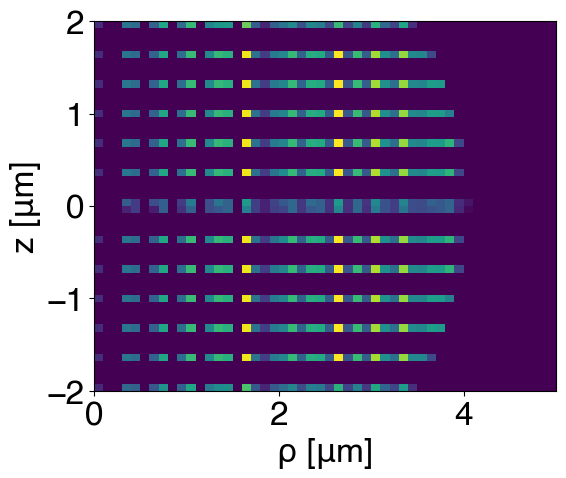

In [8]:
rhoarr = np.array(rhopos)
zarr = np.array(zpos)
print(len(rhoarr))
heatmap, rhoedges, zedges = np.histogram2d(rhoarr, zarr, bins=50, weights=1./(rhoarr+ 1), range=[[0, 5], [-2, 2]])
extent = [rhoedges[0], rhoedges[-1], zedges[0], zedges[-1]]

heatmap = heatmap
_ = plt.clf()
_ = plt.imshow(heatmap.T, extent=extent, origin='lower')
_ = plt.xlabel("ρ [μm]")
_ = plt.ylabel("z [μm]")

In [12]:
# Make n randomly distributed points in a LxLxL box
n = 1000
L = 5
l = .125

points = np.random.rand(n, 3) * L
directions = points/np.linalg.norm(points)

# Make data that looks like a sylinder data
sy_dat = np.zeros((n, 8, 1))
sy_dat[:, 2:5, 0] = points - .5*l*directions
sy_dat[:, 5:8, 0] = points + .5*l*directions

# Create nematic tensor
nematic_tensor_arr = aa.nematic_order.make_nematic_tensor_arr(directions)
print(nematic_tensor_arr.shape)

# Fourier transform the nematic tensor
fQ_arr = aa.nematic_order.fourier_transform_nematic_tensor_arr(nematic_tensor_arr, points, k=[.0,.0,1])

# Find structure factor
Snm = np.einsum('nij,mij->nm', fQ_arr, fQ_arr.conj()) 
Sfact = np.mean(Snm)
print(Sfact.real)


(1000, 3, 3)
0.0809095687506347


In [52]:
k_points = 50
n = 1000
L = 5
# l = .125

points = np.random.rand(n, 3) * L
directions = points/np.linalg.norm(points)

k_arr = np.linspace(0.001, 5., k_points)
# k_arr = np.vstack([np.zeros(k_points), np.zeros(k_points), k_arr]).T
k_arr = np.vstack([np.zeros(k_points), k_arr, np.zeros(k_points)]).T
Q_arr = aa.nematic_order.make_nematic_tensor_arr(directions)

S_arr = np.zeros(k_points)

for i in range(k_points):
    S_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, points, k_arr[i])

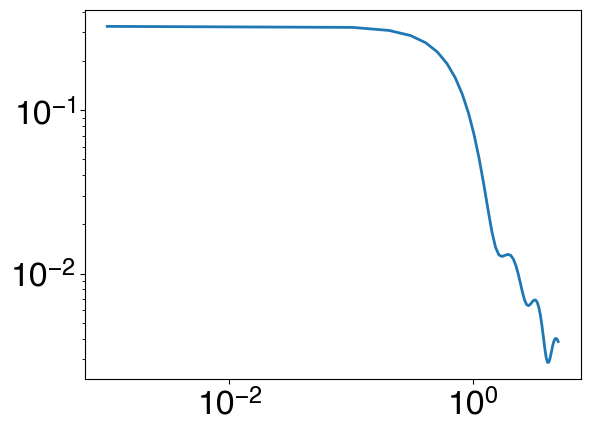

In [53]:
plt.loglog(k_arr[:,1], S_arr)

In [66]:
k_points = 50
n = 1000
L = .1
# l = .125

points = np.random.rand(n, 3) * L
# directions = points/np.linalg.norm(points)
directions = np.tile(np.array([0,0,1]), (n, 1))
print(directions.shape)

k_arr = np.linspace(1./L, n/L, k_points)
k_arr = np.vstack([np.zeros(k_points), np.zeros(k_points), k_arr]).T
# k_arr = np.vstack([np.zeros(k_points), k_arr, np.zeros(k_points)]).T
Q_arr = aa.nematic_order.make_nematic_tensor_arr(directions)

S_arr = np.zeros(k_points)

for i in range(k_points):
    S_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, points, k_arr[i])

(1000, 3)


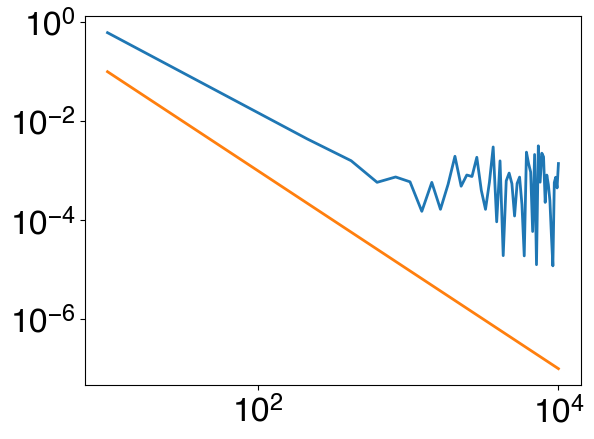

In [69]:
plt.loglog(k_arr[:,2], S_arr)
plt.loglog(k_arr[:,2], 10/k_arr[:,2]**2)

In [5]:
alens_data_path = Path.home() / 'projects/DATA/my_alens_data/IsoNemTesting/'
alens_data_path.exists()
opts = lambda: None 
opts.path = alens_data_path / 'NemN8000ld5rho.4dte-5' # Notice the different path
opts.analysis = 'collect'
opts.analysis_dir = opts.path / 'analysis'
opts.analysis_dir.mkdir(exist_ok=True)

# aa.seed_analysis(opts)

True

In [6]:
with h5py.File(next(opts.analysis_dir.glob('raw*.h5')), 'r') as h5_data:
    param_dict = yaml.load(h5_data.attrs['RunConfig'], Loader=yaml.FullLoader)  
    protein_dict = yaml.load(h5_data.attrs['ProteinConfig'], Loader=yaml.FullLoader)  
    box_lower = np.array(param_dict['simBoxLow'])
    box_upper = np.array(param_dict['simBoxHigh'])
    time_arr = h5_data['time'][:] 
    sy_dat = h5_data['raw_data/sylinders'][...]
    sy_dat = aa.helpers.apply_pbc_to_raw_syl_data(sy_dat, box_lower, box_upper)

In [77]:
k_points = 100 
com_arr = .5 * (sy_dat[:, 2:5, -1] + sy_dat[:, 5:8, -1])
dir_arr = sy_dat[:, 5:8, -1] - sy_dat[:, 2:5, -1]

k_arr = np.logspace(-1, 2, k_points)
k_arr = np.vstack([np.zeros(k_points), np.zeros(k_points), k_arr]).T
# k_arr = np.vstack([np.zeros(k_points), k_arr, np.zeros(k_points)]).T
Q_arr = aa.nematic_order.make_nematic_tensor_arr(dir_arr)

S_arr = np.zeros(k_points)

for i in range(k_points):
    S_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, com_arr, k_arr[i])



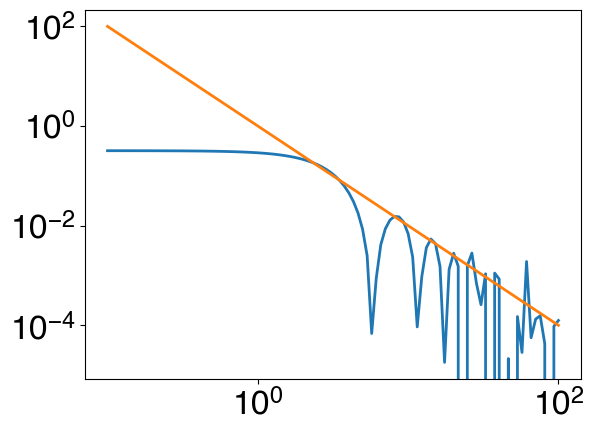

In [82]:
plt.loglog(k_arr[:,2], S_arr)
plt.loglog(k_arr[:,2], 1/k_arr[:,2]**2)

Text(0.5, 0, 'k [μm$^{-1}$]')

Text(0, 0.5, 'S(k)')

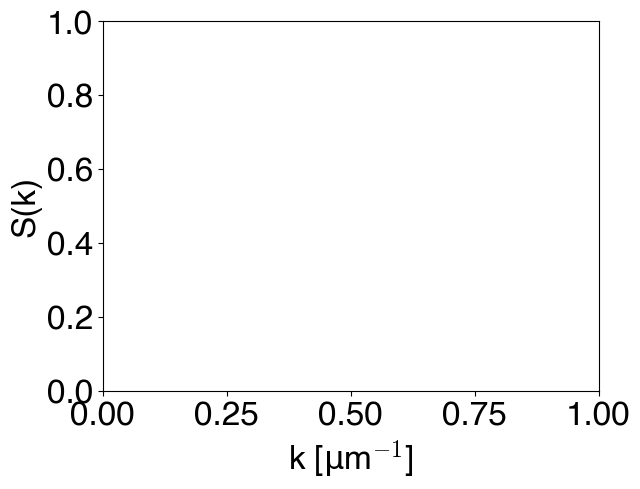

In [17]:
k_points = 100 
com_arr = .5 * (sy_dat[:, 2:5, -1] + sy_dat[:, 5:8, -1])
dir_arr = sy_dat[:, 5:8, -1] - sy_dat[:, 2:5, -1]

k_arr = np.logspace(-1, 2, k_points)
kx_arr = np.vstack([k_arr, np.zeros(k_points), np.zeros(k_points)]).T
ky_arr = np.vstack([np.zeros(k_points), k_arr, np.zeros(k_points)]).T
kz_arr = np.vstack([np.zeros(k_points), np.zeros(k_points), k_arr]).T
Q_arr = aa.nematic_order.make_nematic_tensor_arr(dir_arr)

Sx_arr = np.zeros(k_points)
Sy_arr = np.zeros(k_points)
Sz_arr = np.zeros(k_points)

for i in range(k_points):
    Sx_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, com_arr, kx_arr[i])
    Sy_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, com_arr, ky_arr[i])
    Sz_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, com_arr, kz_arr[i])



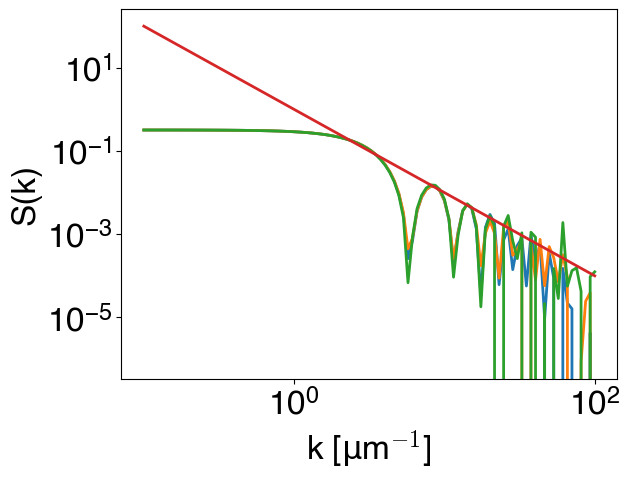

In [ ]:
_ = plt.loglog(kx_arr[:,0], Sx_arr)
_ = plt.loglog(ky_arr[:,1], Sy_arr)
_ = plt.loglog(kz_arr[:,2], Sz_arr)
_ = plt.loglog(kx_arr[:,0], 1/kx_arr[:,0]**2)

_ = plt.xlabel('k [μm$^{-1}$]')
_ = plt.ylabel('S(k)')


In [20]:
k_points = 100 
com_arr = .5 * (sy_dat[:, 2:5, -1] + sy_dat[:, 5:8, -1])
dir_arr = sy_dat[:, 5:8, -1] - sy_dat[:, 2:5, -1]

k_arr = np.logspace(-1, 2, k_points)
kx_arr = np.vstack([k_arr, np.zeros(k_points), np.zeros(k_points)]).T
ky_arr = np.vstack([np.zeros(k_points), k_arr, np.zeros(k_points)]).T
kz_arr = np.vstack([np.zeros(k_points), np.zeros(k_points), k_arr]).T
Q_arr = aa.nematic_order.make_nematic_tensor_arr(dir_arr)
Q_arr -= Q_arr.mean(axis=0)

Sx_arr = np.zeros(k_points)
Sy_arr = np.zeros(k_points)
Sz_arr = np.zeros(k_points)

for i in range(k_points):
    Sx_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, com_arr, kx_arr[i])
    Sy_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, com_arr, ky_arr[i])
    Sz_arr[i] = aa.nematic_order.make_structure_factor(Q_arr, com_arr, kz_arr[i])



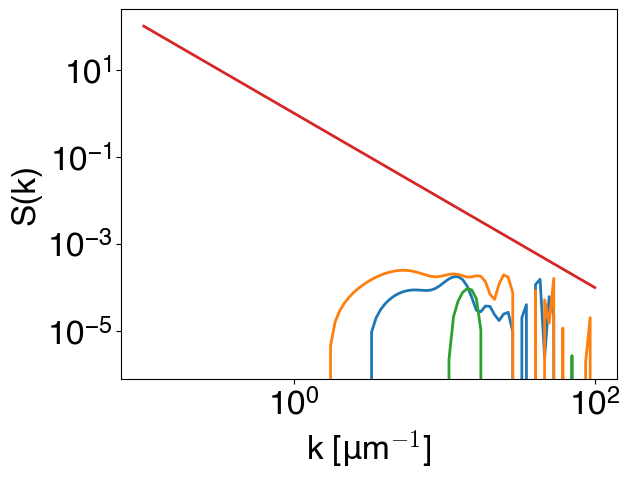

In [21]:
_ = plt.loglog(kx_arr[:,0], Sx_arr)
_ = plt.loglog(ky_arr[:,1], Sy_arr)
_ = plt.loglog(kz_arr[:,2], Sz_arr)
_ = plt.loglog(kx_arr[:,0], 1/kx_arr[:,0]**2)

_ = plt.xlabel('k [μm$^{-1}$]')
_ = plt.ylabel('S(k)')


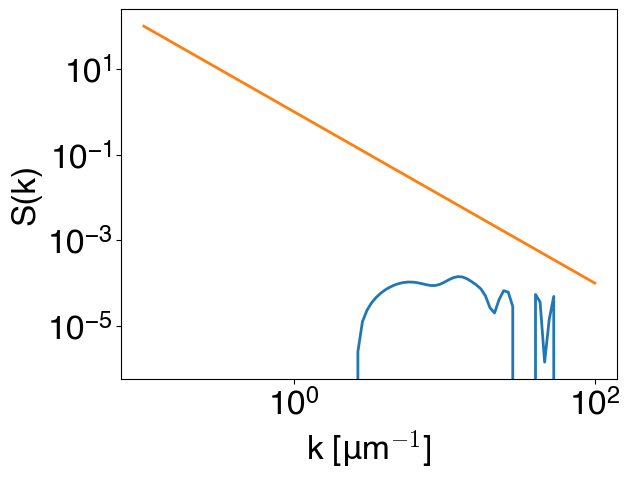

In [22]:
_ = plt.loglog(kx_arr[:,0], (1./3.) * (Sx_arr + Sy_arr + Sz_arr))
_ = plt.loglog(kx_arr[:,0], 1/kx_arr[:,0]**2)
_ = plt.xlabel('k [μm$^{-1}$]')
_ = plt.ylabel('S(k)')

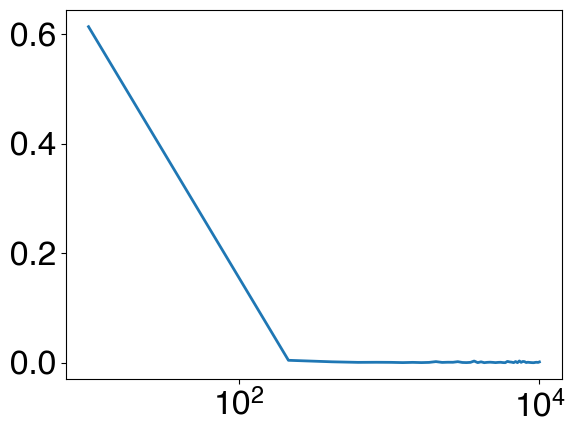

In [76]:
# plt.semilogy(k_arr[:,2], S_arr)
plt.semilogx(k_arr[:,2], S_arr)

In [73]:
# Make a diagnol matrix
n = 10
diag_mat = np.diag(np.arange(n))
print(diag_mat)


[[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]
